<a id='top'></a>
<a name="top"></a><!--Need for Colab-->
# Chapter 15 – Processing Sequences Using RNNs and CNNs

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

1. [Setup](#setup)
2. [Recurrent Sequences Using RNNs and CNNs](#2.0)
    * 2.1 [Memory Cells](#2.1)
    * 2.2 [Input and Output Sequences](#2.2)
3. [Training RNNs](#3.0)
4. [Forecasting a Time Series](#4.0)
    * 4.1 [Baseline Metrics](#4.1.1)
        - 4.1.1 [Naive Forecasting](#4.1.1)
        - 4.1.2 [Simple Linear Regression](#4.1.2)
    * 4.2 [Implementing a SimpleRNN](#4.2)
    * 4.3 [Deep RNNs](#4.3)
        - 4.3.1 [SimpleRNN layers](#4.3.1)
        - 4.3.2 [SimpleRNN + Dense layers](#4.3.2)
    * 4.4 [Forecasting Several Time Steps Ahead](#4.4)
        - 4.4.1 [Step-ahead model for 10 values](#4.4.1)
        - 4.4.2 [Next 10 values, sequence-to-vector RNN model](#4.4.2)
        - 4.4.3 [Next 10 values, sequence-to-sequence RNN model](#4.4.3)
        - 4.4.4 [Create an RNN that predicts the next 10 steps at each time step](#4.4.4)
5. [Handling Long Sequences](#5.0)
    * 5.1 [Fighting the Unstable Gradients Problem](#5.1)
    * 5.2 [Tackling the Short-Term Memory Problem](#5.2)
        - 5.2.1 [Creating a Custom RNN Class](#5.2.1)
        - 5.2.2 [LSTMs](#5.2.2)
        - 5.2.3 [GRUs](#5.2.3)
        - 5.2.4 [Using One-Dimensional Convolutional Layers to Process Sequences](#5.2.4)
        - 5.2.5 [WaveNet](#5.2.5)
        - 5.2.6 [Original WaveNet](#5.2.6)

---
<a id='setup'></a>
<a name="setup"></a>
# 1. Setup
<a href="#top">[back to top]</a>

In [31]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt

# global seed
tf.random.set_seed(42)
pp = pprint.PrettyPrinter(indent=4)

print("Loaded libraries.")

EPOCHS_N = 20

def HR():
    print("-"*40)

Loaded libraries.


---
<a id='2.0'></a>
<a name="2.0"></a>
# 2.0 Recurrent Neurons and Layers
<a href="#top">[back to top]</a>

No source code

<a id='2.1'></a>
<a name="2.1"></a>
## 2.1 Memory Cells
<a href="#top">[back to top]</a>

No source code

<a id='2.2'></a>
<a name="2.2"></a>
## 2.2 Input and Output Sequences
<a href="#top">[back to top]</a>

No source code

---
<a id='3.0'></a>
<a name="3.0"></a>
# 3.0 Recurrent Neurons and Layers
<a href="#top">[back to top]</a>

No source code

---
<a id='4.0'></a>
<a name="4.0"></a>
# 4.0 Forecasting a Time Series
<a href="#top">[back to top]</a>

In [2]:
# Create univariate series
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
from dataclasses import dataclass, field
import numpy as np

@dataclass(frozen=False)
class DataTimeSeries:
    series: np.ndarray = np.array([])
    X_train: np.ndarray = np.array([])
    X_valid: np.ndarray = np.array([])
    X_test: np.ndarray = np.array([])
    y_train: np.ndarray = np.array([])
    y_valid: np.ndarray = np.array([])
    y_test: np.ndarray = np.array([])
    n_steps: int = 0

    
# Create a training set, validation set, and test set.
# Since we want to forecast a single value for each series,
# that targets are columns vectors (eg y_train has shape [7000, 1]
def listing4_0_data():
    np.random.seed(42)
    tf.random.set_seed(42)
    
    n_steps = 50
    series = generate_time_series(10000, n_steps + 1)
    X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
    X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
    X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

    return DataTimeSeries (
        series = series,
        X_train = X_train,
        X_valid = X_valid,
        X_test = X_test,
        y_train = y_train,
        y_valid = y_valid,
        y_test = y_test,
        n_steps = n_steps
    )

data_ts = listing4_0_data()

print(f"X_train shape:{data_ts.X_train.shape}")
print(f"y_train shape: {data_ts.y_train.shape}")

X_train shape:(7000, 50, 1)
y_train shape: (7000, 1)


In [4]:
# Note: in this notebook, the blue dots represent targets, and red crosses represent predictions. 

# Added the n_steps parameter here
def plot_series(series, n_steps, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

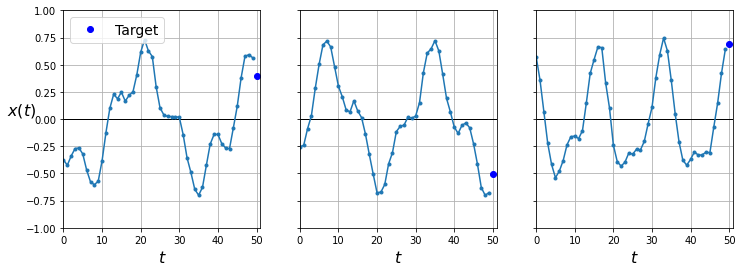

In [5]:
def listing4_0(data):
    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
    for col in range(3):
        plt.sca(axes[col])
        plot_series(
            data.X_valid[col, :, 0], 
            data.n_steps,
            data.y_valid[col, 0],
            y_label=("$x(t)$" if col==0 else None),
            legend=(col == 0),
            
        )
    plt.show()

listing4_0(data_ts)

<a id='4.1'></a>
<a name="4.1"></a>
## 4.1 Baseline Metrics
<a href="#top">[back to top]</a>

No source code

<a id='4.1.1'></a>
<a name="4.1.1"></a>
### 4.1.1 Naive Forecasting
<a href="#top">[back to top]</a>

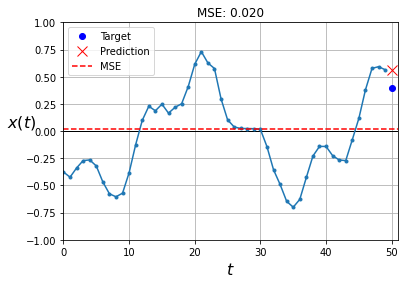

In [6]:
def listing4_1_1(data):

    # Naive predictions (just predict the last observed value)
    y_pred = data.X_valid[:, -1]
    y_pred_mean = np.mean(keras.losses.mean_squared_error(data.y_valid, y_pred))
    # print("MSE:", y_pred_mean)
    # HR()
    
    plot_series(
        data.X_valid[0, :, 0], 
        data.n_steps,
        data.y_valid[0, 0], 
        y_pred[0, 0]
    )
    plt.axhline(y = y_pred_mean, color = 'r', linestyle = '--', label="MSE")
    plt.title(f"MSE: {y_pred_mean:.3f}")
    plt.legend()
    plt.show()

listing4_1_1(data_ts)

In [7]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

<a id='4.1.2'></a>
<a name="4.1.2"></a>
### 4.1.2 Simple Linear Regression
<a href="#top">[back to top]</a>

X_train has shape of (7000, 50, 1), hence when we a Dense layer with it, we will have at least 50 parameters.
----------------------------------------
Epoch 1/20
219/219 - 3s - loss: 0.1001 - val_loss: 0.0545 - 3s/epoch - 14ms/step
Epoch 2/20
219/219 - 1s - loss: 0.0379 - val_loss: 0.0266 - 502ms/epoch - 2ms/step
Epoch 3/20
219/219 - 0s - loss: 0.0202 - val_loss: 0.0157 - 423ms/epoch - 2ms/step
Epoch 4/20
219/219 - 0s - loss: 0.0131 - val_loss: 0.0116 - 489ms/epoch - 2ms/step
Epoch 5/20
219/219 - 0s - loss: 0.0103 - val_loss: 0.0098 - 494ms/epoch - 2ms/step
Epoch 6/20
219/219 - 0s - loss: 0.0089 - val_loss: 0.0087 - 422ms/epoch - 2ms/step
Epoch 7/20
219/219 - 0s - loss: 0.0080 - val_loss: 0.0079 - 427ms/epoch - 2ms/step
Epoch 8/20
219/219 - 0s - loss: 0.0073 - val_loss: 0.0071 - 422ms/epoch - 2ms/step
Epoch 9/20
219/219 - 0s - loss: 0.0066 - val_loss: 0.0066 - 460ms/epoch - 2ms/step
Epoch 10/20
219/219 - 0s - loss: 0.0061 - val_loss: 0.0062 - 439ms/epoch - 2ms/step
Epoch 11/20
219/219 

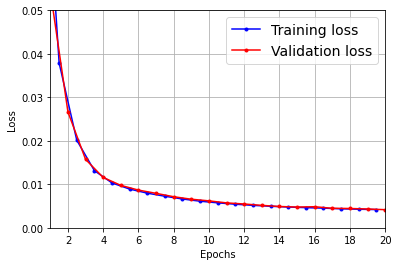

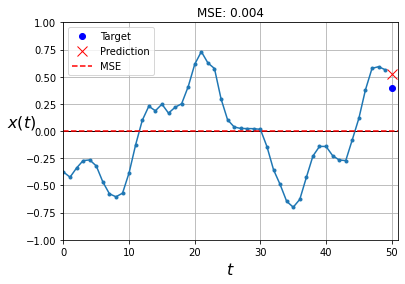

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Linear predictions.
# This approach uses a fully connected network. 
# Since it expects a flat list of features for each input, 
# we need to add a Flatten layer. 
def listing4_1_2(data):

    np.random.seed(42)
    tf.random.set_seed(42)

    print(f"X_train has shape of {data.X_train.shape}, hence when we a Dense layer with it, we will have at least 50 parameters.")
    HR()
    
    # This is a simple Linear Regression model, where each prediction
    # will be a linear combination of the values in the time series
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[50, 1]),
        keras.layers.Dense(1)
    ])

    model.compile(
        loss="mse", 
        optimizer="adam"
    )
    
    history = model.fit(
        data.X_train, 
        data.y_train, 
        epochs=EPOCHS_N,
        validation_data=(data.X_valid, data.y_valid),
        verbose=2
    )

    HR()
    
    model.evaluate(
        data.X_valid, 
        data.y_valid
    )
    
    HR()
    
    plot_learning_curves(history.history["loss"], history.history["val_loss"])
    plt.show()
    
    y_pred = model.predict(data.X_valid)
    y_pred_mean = np.mean(keras.losses.mean_squared_error(data.y_valid, y_pred))

    plot_series(
        data.X_valid[0, :, 0], 
        # GB: Need to add n_steps here!
        data.n_steps, 
        data.y_valid[0, 0], 
        y_pred[0, 0]
    )
    plt.axhline(y = y_pred_mean, color = 'r', linestyle = '--', label="MSE")
    plt.legend()
    plt.title(f"MSE: {y_pred_mean:.3f}")
    plt.show()

    model.summary()
    
listing4_1_2(data_ts)

<a id='4.2'></a>
<a name="4.2"></a>
## 4.2 Implementing a Simple RNN
<a href="#top">[back to top]</a>

Epoch 1/20
219/219 - 8s - loss: 0.0967 - val_loss: 0.0489 - 8s/epoch - 37ms/step
Epoch 2/20
219/219 - 7s - loss: 0.0369 - val_loss: 0.0296 - 7s/epoch - 31ms/step
Epoch 3/20
219/219 - 8s - loss: 0.0253 - val_loss: 0.0218 - 8s/epoch - 35ms/step
Epoch 4/20
219/219 - 7s - loss: 0.0198 - val_loss: 0.0177 - 7s/epoch - 31ms/step
Epoch 5/20
219/219 - 8s - loss: 0.0166 - val_loss: 0.0151 - 8s/epoch - 37ms/step
Epoch 6/20
219/219 - 7s - loss: 0.0146 - val_loss: 0.0134 - 7s/epoch - 32ms/step
Epoch 7/20
219/219 - 7s - loss: 0.0132 - val_loss: 0.0123 - 7s/epoch - 33ms/step
Epoch 8/20
219/219 - 7s - loss: 0.0124 - val_loss: 0.0116 - 7s/epoch - 31ms/step
Epoch 9/20
219/219 - 7s - loss: 0.0118 - val_loss: 0.0112 - 7s/epoch - 31ms/step
Epoch 10/20
219/219 - 7s - loss: 0.0116 - val_loss: 0.0110 - 7s/epoch - 30ms/step
Epoch 11/20
219/219 - 7s - loss: 0.0114 - val_loss: 0.0109 - 7s/epoch - 31ms/step
Epoch 12/20
219/219 - 7s - loss: 0.0114 - val_loss: 0.0109 - 7s/epoch - 31ms/step
Epoch 13/20
219/219 - 7s 

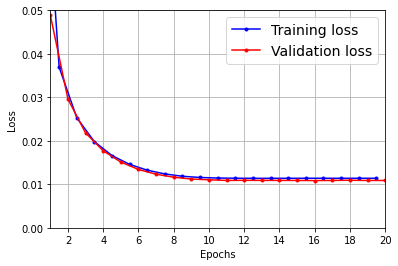

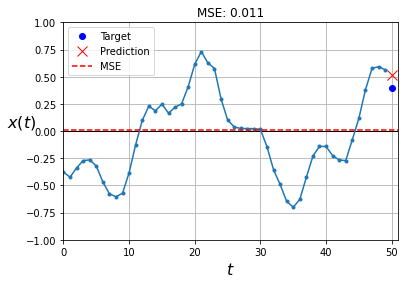

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [9]:
def listing4_2(data):
    
    np.random.seed(42)
    tf.random.set_seed(42)

    # This is the simplest RNN you can build.
    # This is just a single layer with a single neuron.
    # Here we don't need to specify the length of the input sequences,
    # since a RNN can process any number of time steps.
    
    model = keras.models.Sequential([
        keras.layers.SimpleRNN(1, input_shape=[None, 1])
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.005)
    
    model.compile(
        loss="mse", 
        optimizer=optimizer
    )
    
    history = model.fit(
        data.X_train, 
        data.y_train, 
        epochs=EPOCHS_N,
        validation_data=(data.X_valid, data.y_valid),
        verbose=2
    )
    
    HR()
    
    model.evaluate(data.X_valid, data.y_valid)
    
    HR()
    
    plot_learning_curves(history.history["loss"], history.history["val_loss"])
    plt.show()
    
    y_pred = model.predict(data.X_valid)
    y_pred_mean = np.mean(keras.losses.mean_squared_error(data.y_valid, y_pred))

    plot_series(
        data.X_valid[0, :, 0], 
        # Need to add n_steps here
        data.n_steps, 
        data.y_valid[0, 0], 
        y_pred[0, 0]
    )
    plt.axhline(y = y_pred_mean, color = 'r', linestyle = '--', label="MSE")
    plt.legend()
    plt.title(f"MSE: {y_pred_mean:.3f}")
    plt.show()
    
    model.summary()
    
listing4_2(data_ts)

<a id='4.3'></a>
<a name="4.3"></a>
## 4.3 Deep RNNs
<a href="#top">[back to top]</a>

No source code

<a id='4.3.1'></a>
<a name="4.3.1"></a>
### 4.3.1 SimpleRNN layers
<a href="#top">[back to top]</a>

Epoch 1/20
219/219 - 26s - loss: 0.0492 - val_loss: 0.0090 - 26s/epoch - 117ms/step
Epoch 2/20
219/219 - 24s - loss: 0.0070 - val_loss: 0.0065 - 24s/epoch - 109ms/step
Epoch 3/20
219/219 - 25s - loss: 0.0053 - val_loss: 0.0045 - 25s/epoch - 113ms/step
Epoch 4/20
219/219 - 25s - loss: 0.0045 - val_loss: 0.0040 - 25s/epoch - 113ms/step
Epoch 5/20
219/219 - 24s - loss: 0.0042 - val_loss: 0.0040 - 24s/epoch - 108ms/step
Epoch 6/20
219/219 - 24s - loss: 0.0038 - val_loss: 0.0036 - 24s/epoch - 112ms/step
Epoch 7/20
219/219 - 24s - loss: 0.0038 - val_loss: 0.0040 - 24s/epoch - 109ms/step
Epoch 8/20
219/219 - 25s - loss: 0.0037 - val_loss: 0.0033 - 25s/epoch - 115ms/step
Epoch 9/20
219/219 - 24s - loss: 0.0036 - val_loss: 0.0032 - 24s/epoch - 109ms/step
Epoch 10/20
219/219 - 24s - loss: 0.0035 - val_loss: 0.0031 - 24s/epoch - 111ms/step
Epoch 11/20
219/219 - 24s - loss: 0.0034 - val_loss: 0.0030 - 24s/epoch - 108ms/step
Epoch 12/20
219/219 - 25s - loss: 0.0033 - val_loss: 0.0031 - 25s/epoch - 

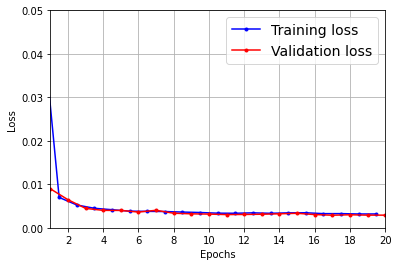

----------------------------------------


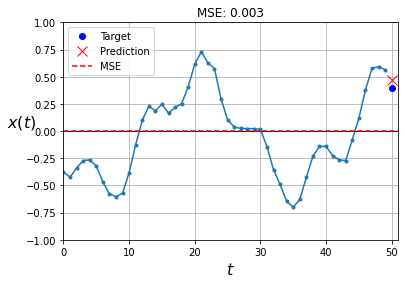

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [10]:
def listing4_3_1(data):

    np.random.seed(42)
    tf.random.set_seed(42)

    # Implement a deep RNN by stacking recurrent layers.
    # Here we use three SimpleRNN layers, but we could have used any type of 
    # recurrent layer, such as LSTM or GRU.
    model = keras.models.Sequential([
        
        # Make sure to set return_sequences=True for all recurrent layers, except the last one.
        # If you don't, they will output a 2D array containing only the output of the last time step,
        # instead of a 3D array which contains outputs for all time steps. In this case, the next
        # recurrent layer will complain you are not feeding it sequences in the expected 3D format.
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20, return_sequences=True),
        
        # A SimpleRNN uses the tanh activation function by default, so the predicted values must lie 
        # within the range of -1 to 1
        keras.layers.SimpleRNN(1)
    ])

    model.compile(
        loss="mse", 
        optimizer="adam"
    )
    
    history = model.fit(
        data.X_train, 
        data.y_train, 
        epochs=EPOCHS_N,
        validation_data=(data.X_valid, data.y_valid),
        verbose=2
    )
    
    HR()
    
    model.evaluate(data.X_valid, data.y_valid)
    
    HR()
    
    plot_learning_curves(history.history["loss"], history.history["val_loss"])
    plt.show()
    
    HR()
    
    y_pred = model.predict(data.X_valid)
    y_pred_mean = np.mean(keras.losses.mean_squared_error(data.y_valid, y_pred))

    plot_series(
        data.X_valid[0, :, 0], 
        # Need to add n_steps here!
        data.n_steps,
        data.y_valid[0, 0], 
        y_pred[0, 0]
    )
    plt.axhline(y = y_pred_mean, color = 'r', linestyle = '--', label="MSE")
    plt.legend()
    plt.title(f"MSE: {y_pred_mean:.3f}")
    plt.show()

    model.summary()
        
listing4_3_1(data_ts)

<a id='4.3.2'></a>
<a name="4.3.2"></a>
### 4.3.2 SimpleRNN + Dense layers
<a href="#top">[back to top]</a>

Epoch 1/20
219/219 - 18s - loss: 0.0232 - val_loss: 0.0052 - 18s/epoch - 81ms/step
Epoch 2/20
219/219 - 15s - loss: 0.0043 - val_loss: 0.0036 - 15s/epoch - 70ms/step
Epoch 3/20
219/219 - 15s - loss: 0.0035 - val_loss: 0.0031 - 15s/epoch - 70ms/step
Epoch 4/20
219/219 - 16s - loss: 0.0033 - val_loss: 0.0033 - 16s/epoch - 72ms/step
Epoch 5/20
219/219 - 15s - loss: 0.0033 - val_loss: 0.0034 - 15s/epoch - 70ms/step
Epoch 6/20
219/219 - 15s - loss: 0.0031 - val_loss: 0.0029 - 15s/epoch - 70ms/step
Epoch 7/20
219/219 - 16s - loss: 0.0031 - val_loss: 0.0034 - 16s/epoch - 75ms/step
Epoch 8/20
219/219 - 15s - loss: 0.0032 - val_loss: 0.0028 - 15s/epoch - 70ms/step
Epoch 9/20
219/219 - 16s - loss: 0.0031 - val_loss: 0.0028 - 16s/epoch - 71ms/step
Epoch 10/20
219/219 - 16s - loss: 0.0030 - val_loss: 0.0029 - 16s/epoch - 71ms/step
Epoch 11/20
219/219 - 15s - loss: 0.0029 - val_loss: 0.0027 - 15s/epoch - 70ms/step
Epoch 12/20
219/219 - 15s - loss: 0.0030 - val_loss: 0.0031 - 15s/epoch - 69ms/step
E

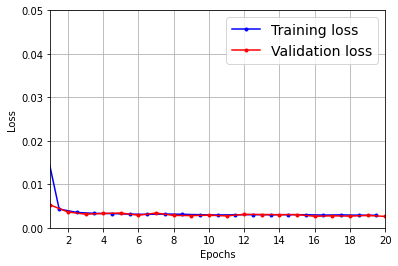

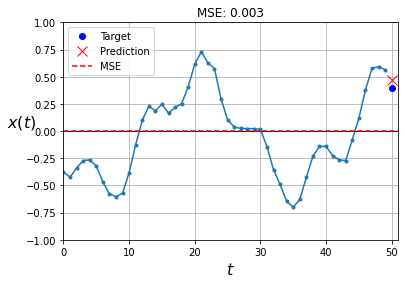

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [11]:
def listing4_3_2(data):

    np.random.seed(42)
    tf.random.set_seed(42)

    model = keras.models.Sequential([
        # Set return_sequences=True to return 3D array
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        
        # return_sequences=False here, so it will return a 2D array, containing only the output of the last time step.
        keras.layers.SimpleRNN(20),
        
        # Replace output layer with a Dense layer. It will run faster, the accuracy is the same,
        # but it allows us to choose any output activation function we want. 
        keras.layers.Dense(1)
    ])

    model.compile(
        loss="mse", 
        optimizer="adam"
    )
    
    history = model.fit(
        data.X_train, 
        data.y_train, 
        epochs=EPOCHS_N,
        validation_data=(data.X_valid, data.y_valid),
        verbose=2
    )
    
    HR()
    
    model.evaluate(
        data.X_valid, 
        data.y_valid
    )
    
    HR()
        
    plot_learning_curves(history.history["loss"], history.history["val_loss"])
    plt.show()

    y_pred = model.predict(data.X_valid)
    y_pred_mean = np.mean(keras.losses.mean_squared_error(data.y_valid, y_pred))

    plot_series(
        data.X_valid[0, :, 0], 
        # Need to add n_steps here
        data.n_steps,
        data.y_valid[0, 0], 
        y_pred[0, 0]
    )
    plt.axhline(y = y_pred_mean, color = 'r', linestyle = '--', label="MSE")
    plt.legend()
    plt.title(f"MSE: {y_pred_mean:.3f}")
    plt.show()
    
    model.summary()
    
    return model

model_rnn_dense=listing4_3_2(data_ts)

<a id='4.4'></a>
<a name="4.4"></a>
## 4.4 Forecasting Several Steps Ahead
<a href="#top">[back to top]</a>

In [12]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    
    ahead = Y.shape[1]
    plot_series(
        X[0, :, 0],
        n_steps,
    )
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)
    plt.show()

<a id='4.4.1'></a>
<a name="4.4.1"></a>
### 4.4.1 Option 1: Step-ahead model for 10 values
<a href="#top">[back to top]</a>

Shape of Y_pred: (1, 10, 1)
----------------------------------------


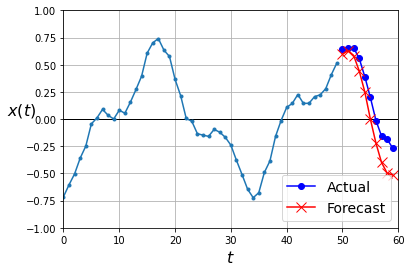

In [13]:
# Predict the next 10 values.
# Option 1 is to use the model we already trained (model_rnn_dense), make it predict the next value,
# then add that value to the inputs (acting as if this predicted value had actually occurred),
# and use the model again to predict the following value, and so on.
def listing4_4_1(model):

    np.random.seed(43) # not 42, as it would duplicate the first series in the train set
    
    n_steps = 50
    
    series = generate_time_series(1, n_steps + 10)
    X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
    X = X_new
    
    for step_ahead in range(10):
        y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]        
        X = np.concatenate([X, y_pred_one], axis=1)

    Y_pred = X[:, n_steps:]
    print(f"Shape of Y_pred: {Y_pred.shape}")
    HR()
        
    plot_multiple_forecasts(X_new, Y_new, Y_pred)
    
listing4_4_1(model_rnn_dense)

<a id='4.4.2'></a>
<a name="4.4.2"></a>
### 4.4.2 Option 2: Predict all 10 next values at once, sequence-to-vector RNN model
<a href="#top">[back to top]</a>

<a id='4.4.3'></a>
<a name="4.4.3"></a>
### 4.4.3 Create an RNN that predicts all 10 next values at once,
<a href="#top">[back to top]</a>

Now let's create an RNN that predicts all 10 next values at once:



Epoch 1/20
219/219 - 17s - loss: 0.0669 - val_loss: 0.0317 - 17s/epoch - 78ms/step
Epoch 2/20
219/219 - 16s - loss: 0.0265 - val_loss: 0.0200 - 16s/epoch - 73ms/step
Epoch 3/20
219/219 - 16s - loss: 0.0183 - val_loss: 0.0160 - 16s/epoch - 72ms/step
Epoch 4/20
219/219 - 16s - loss: 0.0155 - val_loss: 0.0144 - 16s/epoch - 73ms/step
Epoch 5/20
219/219 - 16s - loss: 0.0139 - val_loss: 0.0118 - 16s/epoch - 73ms/step
Epoch 6/20
219/219 - 17s - loss: 0.0128 - val_loss: 0.0112 - 17s/epoch - 76ms/step
Epoch 7/20
219/219 - 16s - loss: 0.0122 - val_loss: 0.0110 - 16s/epoch - 72ms/step
Epoch 8/20
219/219 - 16s - loss: 0.0115 - val_loss: 0.0103 - 16s/epoch - 72ms/step
Epoch 9/20
219/219 - 16s - loss: 0.0111 - val_loss: 0.0112 - 16s/epoch - 73ms/step
Epoch 10/20
219/219 - 16s - loss: 0.0110 - val_loss: 0.0100 - 16s/epoch - 72ms/step
Epoch 11/20
219/219 - 16s - loss: 0.0108 - val_loss: 0.0103 - 16s/epoch - 72ms/step
Epoch 12/20
219/219 - 17s - loss: 0.0102 - val_loss: 0.0096 - 17s/epoch - 78ms/step
E

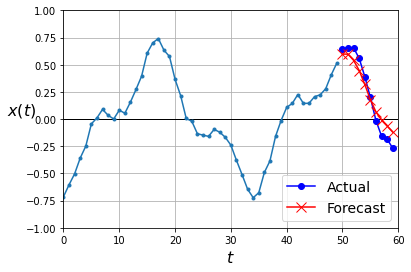

In [14]:
def listing4_4_3():
    
    np.random.seed(42)
    tf.random.set_seed(42)
    
    n_steps = 50
    series = generate_time_series(10_000, n_steps + 10)
    X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
    X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
    X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]


    model = keras.models.Sequential([
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20),
        keras.layers.Dense(10)
    ])

    model.compile(
        loss="mse", 
        optimizer="adam"
    )

    history = model.fit(
        X_train, 
        Y_train, 
        epochs=EPOCHS_N,
        validation_data=(X_valid, Y_valid),
        verbose=2
    )
    
    HR()
    
    np.random.seed(43)

    series = generate_time_series(1, 50 + 10)
    X_new, Y_new = series[:, :50, :], series[:, -10:, :]
    Y_pred = model.predict(X_new)[..., np.newaxis]
    
    plot_multiple_forecasts(X_new, Y_new, Y_pred)
    plt.show()

listing4_4_3()

<a id='4.4.4'></a>
<a name="4.4.4"></a>
### 4.4.4 Create an RNN that predicts the next 10 steps at each time step
<a href="#top">[back to top]</a>

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.



In [15]:
from dataclasses import dataclass, field
import numpy as np

@dataclass(frozen=False)
class DataTimeSeriesTimeStep:
    # series: np.ndarray = np.array([])
    X_train: np.ndarray = np.array([])
    X_valid: np.ndarray = np.array([])
    X_test: np.ndarray = np.array([])
    Y_train: np.ndarray = np.array([])
    Y_valid: np.ndarray = np.array([])
    Y_test: np.ndarray = np.array([])

def data_timeseries_timestep():
    np.random.seed(42)
    
    n_steps = 50
    series = generate_time_series(10000, n_steps + 10)
    X_train = series[:7000, :n_steps]
    X_valid = series[7000:9000, :n_steps]
    X_test = series[9000:, :n_steps]
    
    
    # Each target is a sequence of 100 vectors
    Y = np.empty((10000, n_steps, 10))

    for step_ahead in range(1, 10 + 1):
        Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]

    Y_train = Y[:7000]
    Y_valid = Y[7000:9000]
    Y_test = Y[9000:]

    return DataTimeSeriesTimeStep(
        X_train = X_train,
        X_valid = X_valid,
        X_test = X_test,
        Y_train = Y_train,
        Y_valid = Y_valid,
        Y_test = Y_test,
    )

data_ts_step = data_timeseries_timestep()

In [16]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

Epoch 1/20
219/219 - 17s - loss: 0.0472 - last_time_step_mse: 0.0360 - val_loss: 0.0362 - val_last_time_step_mse: 0.0218 - 17s/epoch - 77ms/step
Epoch 2/20
219/219 - 15s - loss: 0.0351 - last_time_step_mse: 0.0230 - val_loss: 0.0321 - val_last_time_step_mse: 0.0207 - 15s/epoch - 70ms/step
Epoch 3/20
219/219 - 15s - loss: 0.0302 - last_time_step_mse: 0.0186 - val_loss: 0.0329 - val_last_time_step_mse: 0.0226 - 15s/epoch - 70ms/step
Epoch 4/20
219/219 - 16s - loss: 0.0281 - last_time_step_mse: 0.0165 - val_loss: 0.0251 - val_last_time_step_mse: 0.0132 - 16s/epoch - 72ms/step
Epoch 5/20
219/219 - 16s - loss: 0.0254 - last_time_step_mse: 0.0134 - val_loss: 0.0241 - val_last_time_step_mse: 0.0122 - 16s/epoch - 75ms/step
Epoch 6/20
219/219 - 15s - loss: 0.0246 - last_time_step_mse: 0.0122 - val_loss: 0.0250 - val_last_time_step_mse: 0.0134 - 15s/epoch - 70ms/step
Epoch 7/20
219/219 - 15s - loss: 0.0238 - last_time_step_mse: 0.0116 - val_loss: 0.0226 - val_last_time_step_mse: 0.0100 - 15s/epo

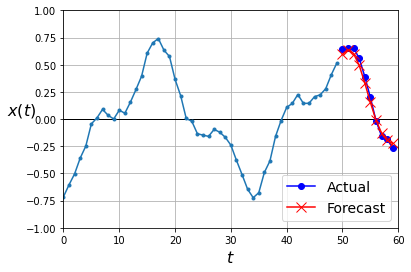

In [17]:
def listing4_4_4(data):

    model = keras.models.Sequential([
        # To turn the model into a sequence-to-sequence model,
        # set return_sequences_True in all recurrent layers,
        # and apply the output Dense layer at every time step.
        # We can use tf.layers.TimeDistributed for this purpose here.
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ])

    model.compile(
        loss="mse", 
        optimizer=keras.optimizers.Adam(learning_rate=0.01), 
        metrics=[last_time_step_mse]
    )

    history = model.fit(
        data.X_train, 
        data.Y_train, 
        epochs=EPOCHS_N,
        validation_data=(data.X_valid, data.Y_valid),
        verbose=2
    )
    
    HR()
    
    np.random.seed(43)

    series = generate_time_series(1, 50 + 10)
    X_new, Y_new = series[:, :50, :], series[:, 50:, :]
    Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

    print(f"Y_pred: {Y_pred}")
    
    plot_multiple_forecasts(X_new, Y_new, Y_pred)
    plt.show()
    
listing4_4_4(data_ts_step)

---
<a id='5.0'></a>
<a name="5.0"></a>
# 5.0 Handling Long Sequences
<a href="#top">[back to top]</a>

No source code

<a id='5.1'></a>
<a name="5.1"></a>
## 5.1 Fighting the Unstable Gradients Problem
<a href="#top">[back to top]</a>

<a id='5.1.1'></a>
<a name="5.1.1"></a>
### 5.1.1 Deep RNN with Batch Normalization
<a href="#top">[back to top]</a>

Epoch 1/20
219/219 - 18s - loss: 0.2113 - last_time_step_mse: 0.2103 - val_loss: 0.0831 - val_last_time_step_mse: 0.0741 - 18s/epoch - 82ms/step
Epoch 2/20
219/219 - 16s - loss: 0.0547 - last_time_step_mse: 0.0445 - val_loss: 0.0542 - val_last_time_step_mse: 0.0422 - 16s/epoch - 71ms/step
Epoch 3/20
219/219 - 16s - loss: 0.0465 - last_time_step_mse: 0.0359 - val_loss: 0.0452 - val_last_time_step_mse: 0.0338 - 16s/epoch - 72ms/step
Epoch 4/20
219/219 - 17s - loss: 0.0423 - last_time_step_mse: 0.0317 - val_loss: 0.0415 - val_last_time_step_mse: 0.0310 - 17s/epoch - 77ms/step
Epoch 5/20
219/219 - 16s - loss: 0.0391 - last_time_step_mse: 0.0282 - val_loss: 0.0379 - val_last_time_step_mse: 0.0272 - 16s/epoch - 72ms/step
Epoch 6/20
219/219 - 16s - loss: 0.0362 - last_time_step_mse: 0.0246 - val_loss: 0.0348 - val_last_time_step_mse: 0.0231 - 16s/epoch - 72ms/step
Epoch 7/20
219/219 - 16s - loss: 0.0343 - last_time_step_mse: 0.0223 - val_loss: 0.0336 - val_last_time_step_mse: 0.0218 - 16s/epo

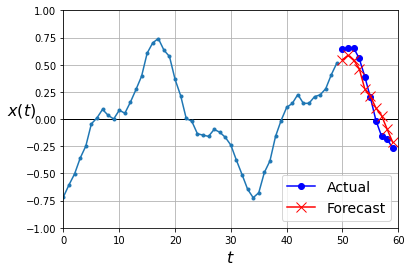

In [18]:
def listing5_1_1(data):

    # Reuse data from listing4_4_4
    def last_time_step_mse(Y_true, Y_pred):
        return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

    model = keras.models.Sequential([
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.BatchNormalization(),
        keras.layers.SimpleRNN(20, return_sequences=True),
        keras.layers.BatchNormalization(),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ])

    model.compile(
        loss="mse", 
        optimizer="adam", 
        metrics=[last_time_step_mse],
    )

    history = model.fit(
        data.X_train, 
        data.Y_train, 
        epochs=EPOCHS_N,
        validation_data=(data.X_valid, data.Y_valid),
        verbose=2
    )
    
    np.random.seed(43)

    series = generate_time_series(1, 50 + 10)
    X_new, Y_new = series[:, :50, :], series[:, 50:, :]
    Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

    HR()
    print(f"Y_pred: {Y_pred}")
    
    plot_multiple_forecasts(X_new, Y_new, Y_pred)
    plt.show()
    
listing5_1_1(data_ts_step)

<a id='5.1.2'></a>
<a name="5.1.2"></a>
### 5.1.2 Deep RNNs with Layer Normalization
<a href="#top">[back to top]</a>

This is very similar to Batch Normalization, but instead of normalizing across the batch dimension, it normalizes across the features dimension. 

In [19]:
from tensorflow.keras.layers import LayerNormalization

# Inherit from keras.layers.Layer class, like any custom layer.
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(
            units,
            activation=None
        )
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

Epoch 1/20
219/219 - 40s - loss: 0.1346 - last_time_step_mse: 0.1249 - val_loss: 0.0687 - val_last_time_step_mse: 0.0586 - 40s/epoch - 182ms/step
Epoch 2/20
219/219 - 38s - loss: 0.0608 - last_time_step_mse: 0.0486 - val_loss: 0.0546 - val_last_time_step_mse: 0.0412 - 38s/epoch - 173ms/step
Epoch 3/20
219/219 - 36s - loss: 0.0546 - last_time_step_mse: 0.0431 - val_loss: 0.0476 - val_last_time_step_mse: 0.0349 - 36s/epoch - 166ms/step
Epoch 4/20
219/219 - 37s - loss: 0.0454 - last_time_step_mse: 0.0318 - val_loss: 0.0472 - val_last_time_step_mse: 0.0366 - 37s/epoch - 169ms/step
Epoch 5/20
219/219 - 35s - loss: 0.0413 - last_time_step_mse: 0.0274 - val_loss: 0.0390 - val_last_time_step_mse: 0.0251 - 35s/epoch - 161ms/step
Epoch 6/20
219/219 - 36s - loss: 0.0378 - last_time_step_mse: 0.0230 - val_loss: 0.0371 - val_last_time_step_mse: 0.0216 - 36s/epoch - 165ms/step
Epoch 7/20
219/219 - 37s - loss: 0.0356 - last_time_step_mse: 0.0208 - val_loss: 0.0337 - val_last_time_step_mse: 0.0195 - 3

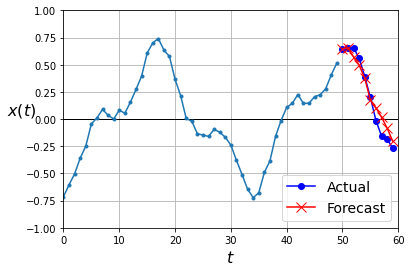

In [20]:
def listing5_1_2(data):

    model = keras.models.Sequential([
        keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
        keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ])

    model.compile(
        loss="mse", 
        optimizer="adam", 
        metrics=[last_time_step_mse]
    )

    history = model.fit(
        data.X_train, 
        data.Y_train, 
        epochs=EPOCHS_N,
        validation_data=(data.X_valid, data.Y_valid),
        verbose=2
    )

    np.random.seed(43)

    series = generate_time_series(1, 50 + 10)
    X_new, Y_new = series[:, :50, :], series[:, 50:, :]
    Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

    HR()
    print(f"Y_pred: {Y_pred}")
    
    plot_multiple_forecasts(X_new, Y_new, Y_pred)
    plt.show()    

listing5_1_2(data_ts_step)

<a id='5.2'></a>
<a name="5.2"></a>
## 5.2 Tackling the Short-Term Memory Problem
<a href="#top">[back to top]</a>

<a id='5.2.1'></a>
<a name="5.2.1"></a>
### 5.2.1 Creating a Custom RNN Class
<a href="#top">[back to top]</a>

In [21]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

Epoch 1/20
219/219 [==============================] - 40s 178ms/step - loss: 0.1678 - last_time_step_mse: 0.1630 - val_loss: 0.0731 - val_last_time_step_mse: 0.0671
Epoch 2/20
219/219 [==============================] - 39s 177ms/step - loss: 0.0639 - last_time_step_mse: 0.0561 - val_loss: 0.0573 - val_last_time_step_mse: 0.0497
Epoch 3/20
219/219 [==============================] - 40s 181ms/step - loss: 0.0546 - last_time_step_mse: 0.0468 - val_loss: 0.0513 - val_last_time_step_mse: 0.0438
Epoch 4/20
219/219 [==============================] - 39s 176ms/step - loss: 0.0488 - last_time_step_mse: 0.0407 - val_loss: 0.0463 - val_last_time_step_mse: 0.0385
Epoch 5/20
219/219 [==============================] - 39s 180ms/step - loss: 0.0435 - last_time_step_mse: 0.0343 - val_loss: 0.0407 - val_last_time_step_mse: 0.0310
Epoch 6/20
219/219 [==============================] - 38s 174ms/step - loss: 0.0398 - last_time_step_mse: 0.0297 - val_loss: 0.0377 - val_last_time_step_mse: 0.0274
Epoch 7/20

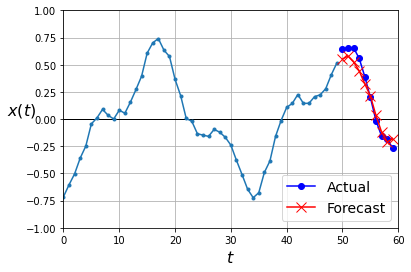

In [22]:
def listing5_2_1(data):
            
    np.random.seed(42)
    tf.random.set_seed(42)

    model = keras.models.Sequential([
        MyRNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
        MyRNN(LNSimpleRNNCell(20), return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ])

    model.compile(
        loss="mse", 
        optimizer="adam", 
        metrics=[last_time_step_mse]
    )

    history = model.fit(
        data.X_train, 
        data.Y_train, 
        epochs=EPOCHS_N,
        validation_data=(data.X_valid, data.Y_valid)
    )
     
    np.random.seed(43)

    series = generate_time_series(1, 50 + 10)
    X_new, Y_new = series[:, :50, :], series[:, 50:, :]
    Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

    HR()
    print(f"Y_pred: {Y_pred}")
    
    plot_multiple_forecasts(X_new, Y_new, Y_pred)
    plt.show()  
        
listing5_2_1(data_ts_step)

<a id='5.2.2'></a>
<a name="5.2.2"></a>
### 5.2.2 LSTMs
<a href="#top">[back to top]</a>

Epoch 1/20
219/219 - 6s - loss: 0.0770 - last_time_step_mse: 0.0618 - val_loss: 0.0533 - val_last_time_step_mse: 0.0312 - 6s/epoch - 29ms/step
Epoch 2/20
219/219 - 2s - loss: 0.0455 - last_time_step_mse: 0.0230 - val_loss: 0.0401 - val_last_time_step_mse: 0.0168 - 2s/epoch - 8ms/step
Epoch 3/20
219/219 - 2s - loss: 0.0372 - last_time_step_mse: 0.0152 - val_loss: 0.0355 - val_last_time_step_mse: 0.0152 - 2s/epoch - 8ms/step
Epoch 4/20
219/219 - 2s - loss: 0.0338 - last_time_step_mse: 0.0134 - val_loss: 0.0324 - val_last_time_step_mse: 0.0125 - 2s/epoch - 8ms/step
Epoch 5/20
219/219 - 2s - loss: 0.0315 - last_time_step_mse: 0.0123 - val_loss: 0.0306 - val_last_time_step_mse: 0.0120 - 2s/epoch - 8ms/step
Epoch 6/20
219/219 - 2s - loss: 0.0299 - last_time_step_mse: 0.0113 - val_loss: 0.0291 - val_last_time_step_mse: 0.0106 - 2s/epoch - 7ms/step
Epoch 7/20
219/219 - 2s - loss: 0.0288 - last_time_step_mse: 0.0107 - val_loss: 0.0284 - val_last_time_step_mse: 0.0108 - 2s/epoch - 7ms/step
Epoch

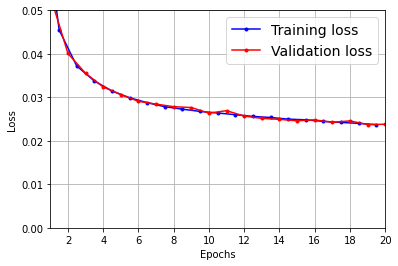

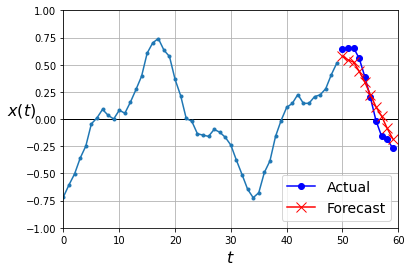

In [23]:
def listing5_2_2(data):
        
    model = keras.models.Sequential([
        keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.LSTM(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ])

    model.compile(
        loss="mse", 
        optimizer="adam", 
        metrics=[last_time_step_mse]
    )

    history = model.fit(
        data.X_train, 
        data.Y_train, 
        epochs=EPOCHS_N,
        validation_data=(data.X_valid, data.Y_valid),
        verbose=2
    )

    model.evaluate(
        data.X_valid, 
        data.Y_valid
    )

    plot_learning_curves(history.history["loss"], history.history["val_loss"])
    plt.show()

    np.random.seed(43)

    series = generate_time_series(1, 50 + 10)
    X_new, Y_new = series[:, :50, :], series[:, 50:, :]
    Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

    plot_multiple_forecasts(X_new, Y_new, Y_pred)
    plt.show()
    
listing5_2_2(data_ts_step)

Epoch 1/20
219/219 - 36s - loss: 0.0764 - last_time_step_mse: 0.0611 - val_loss: 0.0553 - val_last_time_step_mse: 0.0350 - 36s/epoch - 165ms/step
Epoch 2/20
219/219 - 33s - loss: 0.0491 - last_time_step_mse: 0.0283 - val_loss: 0.0436 - val_last_time_step_mse: 0.0226 - 33s/epoch - 149ms/step
Epoch 3/20
219/219 - 33s - loss: 0.0392 - last_time_step_mse: 0.0182 - val_loss: 0.0365 - val_last_time_step_mse: 0.0162 - 33s/epoch - 149ms/step
Epoch 4/20
219/219 - 34s - loss: 0.0346 - last_time_step_mse: 0.0149 - val_loss: 0.0331 - val_last_time_step_mse: 0.0136 - 34s/epoch - 156ms/step
Epoch 5/20
219/219 - 33s - loss: 0.0322 - last_time_step_mse: 0.0133 - val_loss: 0.0315 - val_last_time_step_mse: 0.0129 - 33s/epoch - 148ms/step
Epoch 6/20
219/219 - 33s - loss: 0.0308 - last_time_step_mse: 0.0125 - val_loss: 0.0298 - val_last_time_step_mse: 0.0117 - 33s/epoch - 152ms/step
Epoch 7/20
219/219 - 34s - loss: 0.0297 - last_time_step_mse: 0.0119 - val_loss: 0.0289 - val_last_time_step_mse: 0.0115 - 3

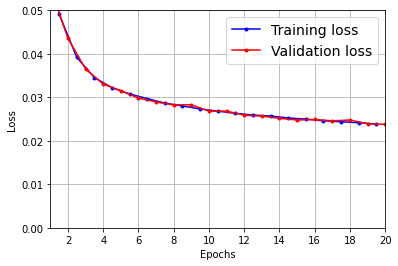

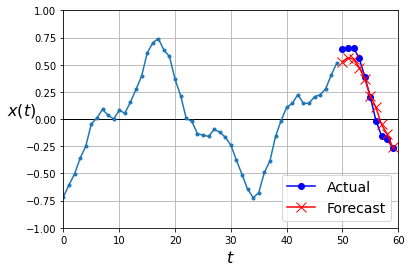

In [24]:
def listing5_2_2b(data):
    
    # Alternatively, we can use the general-purpose layer, giving it an LSTMCell as an argument:
    model = keras.models.Sequential([
        keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True, input_shape=[None, 1]),
        keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ])

    model.compile(
        loss="mse", 
        optimizer="adam", 
        metrics=[last_time_step_mse]
    )

    history = model.fit(
        data.X_train, 
        data.Y_train, 
        epochs=EPOCHS_N,
        validation_data=(data.X_valid, data.Y_valid),
        verbose=2
    )

    model.evaluate(
        data.X_valid, 
        data.Y_valid
    )

    plot_learning_curves(history.history["loss"], history.history["val_loss"])
    plt.show()

    np.random.seed(43)

    series = generate_time_series(1, 50 + 10)
    X_new, Y_new = series[:, :50, :], series[:, 50:, :]
    Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

    plot_multiple_forecasts(X_new, Y_new, Y_pred)
    plt.show()
    
listing5_2_2b(data_ts_step)

<a id='5.2.3'></a>
<a name="5.2.3"></a>
### 5.2.3 GRUs
<a href="#top">[back to top]</a>

Epoch 1/20
219/219 - 5s - loss: 0.0743 - last_time_step_mse: 0.0655 - val_loss: 0.0545 - val_last_time_step_mse: 0.0436 - 5s/epoch - 24ms/step
Epoch 2/20
219/219 - 1s - loss: 0.0492 - last_time_step_mse: 0.0388 - val_loss: 0.0453 - val_last_time_step_mse: 0.0348 - 1s/epoch - 7ms/step
Epoch 3/20
219/219 - 2s - loss: 0.0434 - last_time_step_mse: 0.0327 - val_loss: 0.0411 - val_last_time_step_mse: 0.0299 - 2s/epoch - 7ms/step
Epoch 4/20
219/219 - 1s - loss: 0.0397 - last_time_step_mse: 0.0288 - val_loss: 0.0371 - val_last_time_step_mse: 0.0265 - 1s/epoch - 7ms/step
Epoch 5/20
219/219 - 1s - loss: 0.0352 - last_time_step_mse: 0.0231 - val_loss: 0.0339 - val_last_time_step_mse: 0.0241 - 1s/epoch - 7ms/step
Epoch 6/20
219/219 - 1s - loss: 0.0319 - last_time_step_mse: 0.0174 - val_loss: 0.0305 - val_last_time_step_mse: 0.0161 - 1s/epoch - 7ms/step
Epoch 7/20
219/219 - 1s - loss: 0.0300 - last_time_step_mse: 0.0150 - val_loss: 0.0289 - val_last_time_step_mse: 0.0138 - 1s/epoch - 7ms/step
Epoch

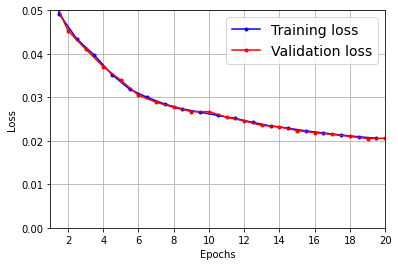

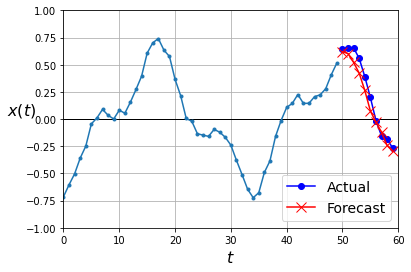

In [25]:
def listing5_2_3(data):
        
    model = keras.models.Sequential([
        keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.GRU(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ])

    model.compile(
        loss="mse", 
        optimizer="adam", 
        metrics=[last_time_step_mse]
    )

    history = model.fit(
        data.X_train, 
        data.Y_train, 
        epochs=EPOCHS_N,
        validation_data=(data.X_valid, data.Y_valid),
        verbose=2
    )

    model.evaluate(
        data.X_valid, 
        data.Y_valid
    )

    plot_learning_curves(history.history["loss"], history.history["val_loss"])
    plt.show()


    np.random.seed(43)

    series = generate_time_series(1, 50 + 10)
    X_new, Y_new = series[:, :50, :], series[:, 50:, :]
    Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]


    plot_multiple_forecasts(X_new, Y_new, Y_pred)
    plt.show()
    
listing5_2_3(data_ts_step)

<a id='5.2.4'></a>
<a name="5.2.4"></a>
### 5.2.4 Using 1D Convolutional Layers to Process Sequences
<a href="#top">[back to top]</a>

<font size=2>

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```
    
</font>

Epoch 1/20
219/219 - 12s - loss: 0.0676 - last_time_step_mse: 0.0590 - val_loss: 0.0463 - val_last_time_step_mse: 0.0367 - 12s/epoch - 53ms/step
Epoch 2/20
219/219 - 1s - loss: 0.0404 - last_time_step_mse: 0.0326 - val_loss: 0.0351 - val_last_time_step_mse: 0.0266 - 1s/epoch - 7ms/step
Epoch 3/20
219/219 - 1s - loss: 0.0327 - last_time_step_mse: 0.0238 - val_loss: 0.0304 - val_last_time_step_mse: 0.0214 - 1s/epoch - 6ms/step
Epoch 4/20
219/219 - 1s - loss: 0.0287 - last_time_step_mse: 0.0184 - val_loss: 0.0271 - val_last_time_step_mse: 0.0164 - 1s/epoch - 6ms/step
Epoch 5/20
219/219 - 1s - loss: 0.0263 - last_time_step_mse: 0.0153 - val_loss: 0.0260 - val_last_time_step_mse: 0.0157 - 1s/epoch - 6ms/step
Epoch 6/20
219/219 - 1s - loss: 0.0247 - last_time_step_mse: 0.0133 - val_loss: 0.0241 - val_last_time_step_mse: 0.0129 - 1s/epoch - 6ms/step
Epoch 7/20
219/219 - 1s - loss: 0.0237 - last_time_step_mse: 0.0123 - val_loss: 0.0238 - val_last_time_step_mse: 0.0125 - 1s/epoch - 6ms/step
Epo

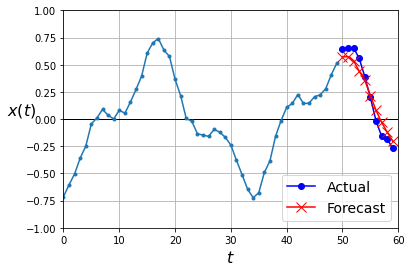

In [26]:
def listing5_2_4(data):
     
    model = keras.models.Sequential([
        keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[None, 1]),
        keras.layers.GRU(20, return_sequences=True),
        keras.layers.GRU(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ])

    model.compile(
        loss="mse", 
        optimizer="adam", 
        metrics=[last_time_step_mse]
    )

    history = model.fit(
        data.X_train, 
        data.Y_train[:, 3::2], 
        epochs=EPOCHS_N,
        validation_data=(data.X_valid, data.Y_valid[:, 3::2]),
        verbose=2
    )
    
    np.random.seed(43)

    series = generate_time_series(1, 50 + 10)
    X_new, Y_new = series[:, :50, :], series[:, 50:, :]
    Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

    ###

    plot_multiple_forecasts(X_new, Y_new, Y_pred)
    plt.show()
    
listing5_2_4(data_ts_step)

<a id='5.2.5'></a>
<a name="5.2.5"></a>
### 5.2.5 WaveNet
<a href="#top">[back to top]</a>

<font size=2>

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```
    
</font>

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0639 - last_time_step_mse: 0.0519 - val_loss: 0.0356 - val_last_time_step_mse: 0.0217
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0319 - last_time_step_mse: 0.0196 - val_loss: 0.0295 - val_last_time_step_mse: 0.0169
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0285 - last_time_step_mse: 0.0165 - val_loss: 0.0273 - val_last_time_step_mse: 0.0151
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0266 - last_time_step_mse: 0.0146 - val_loss: 0.0264 - val_last_time_step_mse: 0.0145
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0254 - last_time_step_mse: 0.0135 - val_loss: 0.0247 - val_last_time_step_mse: 0.0127
Epoch 6/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0245 - last_time_step_mse: 0.0126 - val_loss: 0.0238 - val_last_time_step_mse: 0.0116
Epoch 7/20
219/219 [========

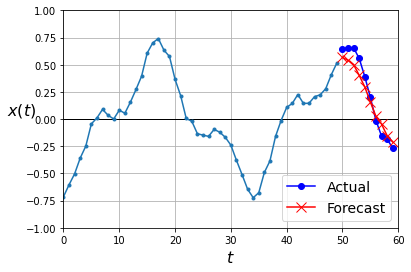

In [27]:
def listing5_2_5(data):
    
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=[None, 1]))
    for rate in (1, 2, 4, 8) * 2:
        model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal", activation="relu", dilation_rate=rate))

    model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

    model.compile(
        loss="mse", 
        optimizer="adam", 
        metrics=[last_time_step_mse]
    )

    history = model.fit(
        data.X_train, 
        data.Y_train, 
        epochs=EPOCHS_N,
        validation_data=(data.X_valid, data.Y_valid)
    )
        
    np.random.seed(43)

    series = generate_time_series(1, 50 + 10)
    X_new, Y_new = series[:, :50, :], series[:, 50:, :]
    Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

    plot_multiple_forecasts(X_new, Y_new, Y_pred)
    plt.show()

listing5_2_5(data_ts_step)

<a id='5.2.6'></a>
<a name="5.2.6"></a>
### 5.2.6 Original WaveNet
<a href="#top">[back to top]</a>

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [28]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [29]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal", dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

Epoch 1/20
219/219 - 3s - loss: 0.1304 - last_time_step_mse: 0.1264 - val_loss: 0.1227 - val_last_time_step_mse: 0.1196 - 3s/epoch - 13ms/step
Epoch 2/20
219/219 - 1s - loss: 0.1221 - last_time_step_mse: 0.1177 - val_loss: 0.1218 - val_last_time_step_mse: 0.1190 - 1s/epoch - 6ms/step
Epoch 3/20
219/219 - 1s - loss: 0.1216 - last_time_step_mse: 0.1173 - val_loss: 0.1215 - val_last_time_step_mse: 0.1187 - 1s/epoch - 6ms/step
Epoch 4/20
219/219 - 1s - loss: 0.1214 - last_time_step_mse: 0.1171 - val_loss: 0.1212 - val_last_time_step_mse: 0.1183 - 1s/epoch - 6ms/step
Epoch 5/20
219/219 - 1s - loss: 0.1212 - last_time_step_mse: 0.1169 - val_loss: 0.1210 - val_last_time_step_mse: 0.1182 - 1s/epoch - 6ms/step
Epoch 6/20
219/219 - 1s - loss: 0.1210 - last_time_step_mse: 0.1167 - val_loss: 0.1209 - val_last_time_step_mse: 0.1180 - 1s/epoch - 6ms/step
Epoch 7/20
219/219 - 1s - loss: 0.1209 - last_time_step_mse: 0.1166 - val_loss: 0.1208 - val_last_time_step_mse: 0.1179 - 1s/epoch - 6ms/step
Epoch

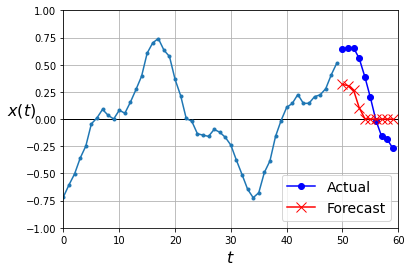

In [30]:
def listing5_2_6(data):

    keras.backend.clear_session()
    
    n_layers_per_block = 3 # 10 in the paper
    n_blocks = 1 # 3 in the paper
    n_filters = 32 # 128 in the paper
    n_outputs = 10 # 256 in the paper

    inputs = keras.layers.Input(shape=[None, 1])
    z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
    skip_to_last = []
    for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
        z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
        skip_to_last.append(skip)
    z = keras.activations.relu(keras.layers.Add()(skip_to_last))
    z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
    Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

    model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])
    
    model.compile(
        loss="mse", 
        optimizer="adam", 
        metrics=[last_time_step_mse]
    )

    history = model.fit(
        data.X_train, 
        data.Y_train, 
        epochs=EPOCHS_N,
        validation_data=(data.X_valid, data.Y_valid),
        verbose=2
    )

    np.random.seed(43)

    series = generate_time_series(1, 50 + 10)
    X_new, Y_new = series[:, :50, :], series[:, 50:, :]
    Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

    plot_multiple_forecasts(X_new, Y_new, Y_pred)
    plt.show()
    
listing5_2_6(data_ts_step)

# Summary 

In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.